# 프로젝트: SentencePiece 사용하기

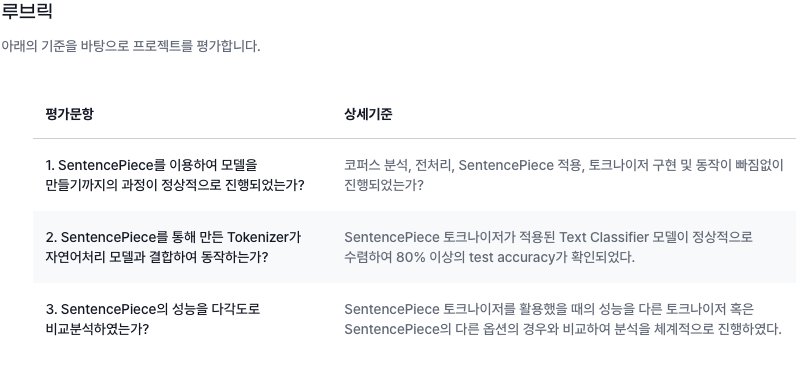

네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 fasttext로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)



- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

In [1]:
import os
import urllib.request

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import sentencepiece as spm
from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

%matplotlib inline

2024-12-12 14:39:18.627156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 데이터셋 로드

In [2]:

def load_dataset(url, data_path):
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    train_url = url + '/ratings_train.txt'
    test_url = url + '/ratings_test.txt'
    
    train_data_path = os.path.join(data_path, 'ratings_train.txt')
    test_data_path = os.path.join(data_path, 'ratings_test.txt')
    
    urllib.request.urlretrieve(train_url, train_data_path)
    urllib.request.urlretrieve(test_url, test_data_path)
    
    print('Data downloaded Successfully')

In [3]:
url = "https://github.com/e9t/nsmc/raw/master"
data_path = os.getenv('HOME')+'/GoingDeeper/data/nsmc'

# load_dataset(url, data_path)

In [4]:
train_path = data_path + '/ratings_train.txt'
test_path = data_path + '/ratings_test.txt'

In [5]:
train = pd.read_csv(train_path, sep='\t')
test = pd.read_csv(test_path, sep='\t')

In [6]:
print(f'{len(train)}개')
train.head()

150000개


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
print(f'{len(test)}개')
test.head()

50000개


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## EDA

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


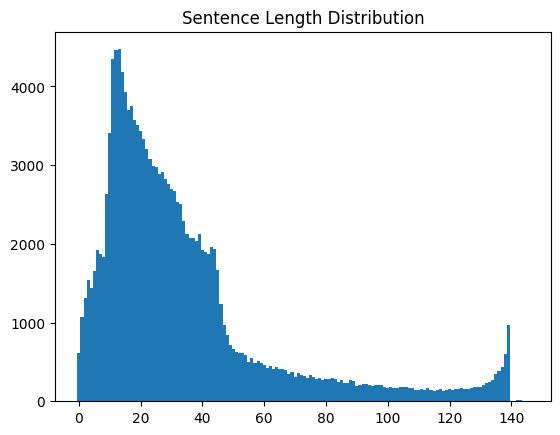

In [8]:
# 문장길이 확인을 위해 document 컬럼 추출
# Document 컬럼의 길이 제일 긴거 확인
# train['document'].str.len().max()
min_len = 999
max_len = 0
sum_len = 0

for sen in train['document']:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len//len(train))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train['document']:
    sentence_length[len(str(sen))-1] += 1

# 시각화
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [9]:
# 특정 길이 문장 전체 찾기 - 개수 파악
def check_sentence_with_length(raw, length):
    cnt = 0
    total_cnt = 0
    for sen in raw['document']:
        if len(str(sen)) == length:
            total_cnt += 1
    print(f'문장 길이가 {length}인 데이터 개수:', total_cnt, "\n")
    
    # 출력물 확인
    for sen in raw['document']:
        if len(str(sen)) == length:
            print(sen)
            cnt += 1
            # 100 이상이면 5개만 출력
            if length >= 100 and cnt >= 3:
                return
            elif cnt >= 10: # 아닌경우 10개 출력
                return

In [10]:
# 문장 길이가 1인 문장 확인
check_sentence_with_length(train, 1)

문장 길이가 1인 데이터 개수: 607 

아
잼
1
4
4
굿
짱
휴
.
1


In [11]:
# 문장 길이가 2인 문장 확인
check_sentence_with_length(train, 2)

문장 길이가 2인 데이터 개수: 1071 

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오


In [12]:
# 문장 길이가 3인 문장 확인
check_sentence_with_length(train, 3)

문장 길이가 3인 데이터 개수: 1311 

좋구나
10점
처ㅝ주
솔직히
4대강
재밌다
재밌군
좋았다
재미무
보지마


In [13]:
# 문장 길이가 4인 문장 확인
check_sentence_with_length(train, 4)

문장 길이가 4인 데이터 개수: 1545 

재밋는뎅
킬링타임
별로다.
볼만해;
연기 굿
좋은영화
굿 좋아
재밌는데
와...
펑점조절


In [14]:
# 문장 길이가 5인 문장 확인
check_sentence_with_length(train, 5)

문장 길이가 5인 데이터 개수: 1445 

재미있어요
전 좋아요
아 빵점~
ㅠㅠ 슬픔
최고의영화
잘봤습니다
쓰레기영화
볼만 한데
짝퉁쓰래기
잼없네요넘


In [15]:
# 문장 길이가 6인 문장 확인
check_sentence_with_length(train, 6)

문장 길이가 6인 데이터 개수: 1653 

심심한영화.
서기가이뻐서
알바는꺼저라
이게 웃겨?
슬프다 ㅠㅠ
즐~~~~~
쇼를해라 쇼
끙.....
좋은 영화~
팔빠다 ㅋㅋ


In [16]:
# 문장 길이가 7인 문장 확인
check_sentence_with_length(train, 7)

문장 길이가 7인 데이터 개수: 1919 

별루 였다..
별점10점가자
감동적인 영화
고다미 괜찮음
걍 둘다 변태
10점 만들기
요즘 재밌음!
할 말이 없다
General
존내재밋습네다


In [17]:
# 문장 길이가 8인 문장 확인
check_sentence_with_length(train, 8)

문장 길이가 8인 데이터 개수: 1867 

카밀라벨 발연기
내용이 이상해;
너무 좋은 영화
가발 쓰고 싶다
0점은 없나??
말랑말랑 ...
그냥. 최고다.
감동적인 영화다
평점 조절...
재미없음 -_-


In [18]:
# 문장 길이가 9인 문장 확인
check_sentence_with_length(train, 9)

문장 길이가 9인 데이터 개수: 1834 

인상적인 영화였다
0점은 못주냐??
괜찮은 영화...
정말 속은느낌이다
절대비추.....
너무너무귀여운영화
전형적인 저질영화
짜장면 되고싶냐?
의지가 모자랍니다
왜만든지모르겟다.


In [19]:
# 문장 길이가 10인 문장 확인
check_sentence_with_length(train, 10)

문장 길이가 10인 데이터 개수: 2636 

매우 실망.....
정말쓰레기영화입니다
내일이 기대되는 `
재미있는영화입니다.
드라마 너무 재밓당
맛깔 나는 드라마.
영화가 내용이 없다
정체성은 사치인가?
재밌음 귀엽고 신남
키기키기키기키기키기


문장길이가 7인거 부터는 쓸만한거 같은데, 그 이후도 ...., 키키키 뭐 이런 노이즈가 많아서 전처리 후에 다시 길이를 봐야겠다

In [20]:
import re
# 한국어 데이터 정규화
def clean_text(texts):
    corpus = []
    for i in range(0, len(texts)):
        # 숫자, 영어, 한국어, !,?를 제외한 모든 문자 제거
        review = re.sub(r"[^0-9a-zA-Zㄱ-ㅎ가-힣!?,]", " ", str(texts[i]))
        review = re.sub(r"[\s]+", " ", review) # 중복 공백 제거
        # 특정단어가 2번이상 반복되는 경우 1번으로 변경
        review = re.sub(r'(\w)\1{1,}', r'\1', review)
        # 특정 기호가 2번이상 반복되는 경우 1번으로 변경
        review = re.sub(r'(!)\1{1,}', r'\1', review)
        # 문장 앞뒤 공백 제거
        review = review.strip()
        corpus.append(review)
    return corpus

train['document'] = clean_text(train['document'])
train['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                              흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                교도소 이야기구먼 솔직히 재미는 없다 평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉 방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object

다시 분포 확인

문장의 최단 길이: 0
문장의 최장 길이: 140
문장의 평균 길이: 32


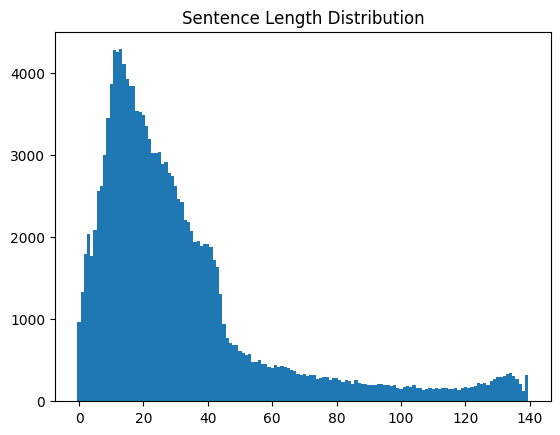

In [21]:

# 문장길이 확인을 위해 document 컬럼 추출
# Document 컬럼의 길이 제일 긴거 확인
# train['document'].str.len().max()
min_len = 999
max_len = 0
sum_len = 0

for sen in train['document']:
    length = len(str(sen))
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    
print('문장의 최단 길이:', min_len)
print('문장의 최장 길이:', max_len)
print('문장의 평균 길이:', sum_len//len(train))

sentence_length = np.zeros((max_len), dtype=int)

for sen in train['document']:
    sentence_length[len(str(sen))-1] += 1

# 시각화
plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [22]:
# 문장 길이가 0인 문장 확인
check_sentence_with_length(train, 0)

문장 길이가 0인 데이터 개수: 261 













In [23]:
# 문장 길이가 1인 문장 확인
check_sentence_with_length(train, 1)

문장 길이가 1인 데이터 개수: 968 

아
굳
잼
즐
끙
1
4
와
ㅇ
4


In [24]:
# 문장 길이가 2인 문장 확인
check_sentence_with_length(train, 2)

문장 길이가 2인 데이터 개수: 1332 

최고
졸작
대박
버려
망함
슬픔
안습
망작
쵝오
쵝오


In [25]:
# 문장 길이가 3인 문장 확인
check_sentence_with_length(train, 3)

문장 길이가 3인 데이터 개수: 1790 

별로다
좋구나
볼만해
10점
처 주
솔직히
4대강
슬프다
재밌다
재밌군


In [26]:
# 문장 길이가 4인 문장 확인
check_sentence_with_length(train, 4)

문장 길이가 4인 데이터 개수: 2038 

재밋는뎅
심한영화
킬링타임
아 빵점
로큰롤!
연기 굿
좋은영화
굿 좋아
재밌는데
말랑말랑


In [27]:
# 문장 길이가 5인 문장 확인
check_sentence_with_length(train, 5)

문장 길이가 5인 데이터 개수: 1773 

재미있어요
전 좋아요
매우 실망
별루 였다
최고의영화
잘봤습니다
쓰레기영화
평점 조절
볼만 한데
좋은 영화


In [28]:
# 문장 길이가 6인 문장 확인
check_sentence_with_length(train, 6)

문장 길이가 6인 데이터 개수: 2093 

서기가이뻐서
알바는꺼저라
이게 웃겨?
그냥 최고다
쇼를해라 쇼
괜찮은 영화
난 별로던데
아씨 울었다
재미잇음매우
좋네 괜찮고


In [29]:
# 문장 길이가 7인 문장 확인
check_sentence_with_length(train, 7)

문장 길이가 7인 데이터 개수: 2563 

내용이 이상해
별점10점가자
공유 존잘!ㅎ
감동적인 영화
고다미 괜찮음
걍 둘다 변태
10점 만들기
요즘 재밌음!
진짜 추천해요
할 말이 없다


In [30]:
# 문장 길이가 8인 문장 확인
check_sentence_with_length(train, 8)

문장 길이가 8인 데이터 개수: 2621 

카밀라벨 발연기
아햏 아햏 아햏
내일이 기대되는
너무 좋은 영화
4대2라니 최악
가발 쓰고 싶다
0점은 없나??
감동적인 영화다
2 2고하자 ㅋ
난 잼있던데 ㅎ


In [31]:
# 문장 길이가 9인 문장 확인
check_sentence_with_length(train, 9)

문장 길이가 9인 데이터 개수: 2998 

인상적인 영화였다
재미있는영화입니다
너무너무 훈하네요
맛깔 나는 드라마
0점은 못주냐??
엔딩이 넘 슬퍼요
정말 최고의 영화
정말 속은느낌이다
안봐도 되는 영화
최고의 농촌드라마


In [32]:
# 문장 길이가 10인 문장 확인
check_sentence_with_length(train, 10)

문장 길이가 10인 데이터 개수: 3458 

정말쓰레기영화입니다
아주 모자라진 않다
정말 실망 스러웟음
드라마 너무 재밓당
영화 재미있드만 ㅎ
신선하네 ,, ,,
답없네, 뭐하는건지
페이스 허거 같음ㅋ
영화가 내용이 없다
정체성은 사치인가?


전처리 후 6미만 데이터는 의미없거나 어떤게 좋은지 안좋은지에 대한 기준이 없음\
=> 6이상의 데이터만 사용

130 ~ 문장 확인

In [33]:
# 문장 길이가 130인 문장 확인
check_sentence_with_length(train, 130)

문장 길이가 130인 데이터 개수: 270 

초딩 때 친척형이 비디오로 빌려와서 봤던 기억이 난다 너무 재미 없었다 근데 나중에 우연히 다시보니 재밌더라 그 땐 왜 그렇게 재미가 없었을까?? 98년이면 내가 초등학교 2학년 때니까 사촌형이 당시 나름 최신 비디오를 빌려온거 같다
소피마르소와의 말같지도 않은 불륜이 내용 다 망침 물론 실제 역사에는 그런 똥같은 이야기는 전혀 없었음 주인공 죽을때 공주는 10살이었음 한마디 만약 미국인과 맞서 싸우는 아메리칸 원주민의 자유 투쟁기였으면 절대 아카데미상 못 받았음
전쟁이후의 아픔을 잘 그린영화마지막 장면이 압권유대인줄 알아 더럽게 여기나 도움이 필요하니동행했던 토마스에게 더러운유태인이라고 말한장면 그러나 유대인척한 사실 유대인가족사진을 보면서 미묘한 감정들을 사슴인형을 밟아까며 대변한다므찐영화


In [34]:
# 문장 길이가 140인 문장 확인
check_sentence_with_length(train, 140)

문장 길이가 140인 데이터 개수: 62 

어렸을 때는 지능이 뒤떨어져 이 영화의 전체적인 흐름과 스토리를, 심지어 그 때문에 반전까지 못 느껴서 루즈하게 느껴졌지만, 나이가 들어 영화의 흐름과 반전을 느낄 정도의 약간은 성숙된 ? 지능을 가지고 보니 영화의 완성도가 상당히 높다 여기게 되었다
타짜는10점받아마땅하다 영화의모든부분이다재밌었다 캐릭터들은원작보다훨씬더매력적으로재현됐고,단역까지모든캐릭터가제몫을했다 긴이야기를아주 딱맞게압축했다 전국중고딩에게섯다열풍을몰고온,막판고니와아귀의설전을전국민이외우게만든작품 영화사에남을장면들이가득담겨있는선물세트
나는 나쁘지 않게 봤다만 대부분의사람들은 뭔가 있어보이면 명작이라고 칭송한단 말이지 니들이 이해못해서 재미없다고 하는 정신승리를 곁들여 말이야 연출은 참신했으나 복선이 진부하고 각 플롯마다 연관성이 부족했다 뭐 이것도 감독이 설계했다하면 할말 없겠지만


In [35]:
# 문장 길이가 100인 문장 확인
check_sentence_with_length(train, 100)

문장 길이가 100인 데이터 개수: 166 

전미 박스 오피스1위 ㅋ 그냥 몰아주기 하는건가 어떻게 이런영화가 1위를 하지 옛날 80 90년대 우뢰매수준의 물폭탄싸움이네 ㅋ 손에서 빔나가나 손에서 물폭탄 나가나 다를게 뭐지?
그만빙돌리고 밝혀지게하면안되나요 ?보려다아직도질끌어짜증나 안봄 여기서또사고터져 또질끌면진짜증날듯 ?빨리빨리밝혀질건밝혀지면서반전이있든지 ?작가님 이드라마사랑하고잼있는데 넘끌어짜증나요
별점 ㅇ점옛날 미이라 생각하고 10,0원이나 주고 뵜는데돈,시간만 날렸음도대체 영화를 통해 말하려는게 뭔지 도통????재미도 감동도 꽝 다른 사람 평점봤으면 안봤을텐데 어휴 아까워


In [36]:
# 문장 길이가 110인 문장 확인
check_sentence_with_length(train, 110)

문장 길이가 110인 데이터 개수: 160 

이 영화를 이제서야 보다니 감히 내 인생 최고의 영화중 하나로 꼽을 수 있을만한 작품 어떻게 살아야할지 나를 위한 고민을 한번 더 하게 되는 시간 그리고 모건 프리먼은 나이가 들어도 여전히 섹시하다
소재는 참 좋아서 삼점준다 제작된 영화는 공포도, 스릴러도 아닌 본분을 잊은 드라마아닌 드라마같은 느낌이다 연기, 연출은 괜찮았다 다만 시작부터 끝까지 지루할 뿐이다 또 어떤 장면들은 살짝 유치했다
장난아니다 무당이란 소재가 그렇게 와닿고 좋은 소재는 아니지만이 영화는 정말 엄청나게 잘 소화시킨거같다 그리고 어째 보면 무당이란소재를 사용한것도 정말 신의 한수다 현실에서의 TV프로그램도 그러니까


In [37]:
# 문장 길이가 120인 문장 확인
check_sentence_with_length(train, 120)

문장 길이가 120인 데이터 개수: 166 

마음 같아서는 별을 끝도 없이 주고싶은데 그러지 못해서 아쉽습니다 감수성 풍부한 남자이지만 드라마를 보면서 울어본적은 없는데 기분좋은날을 보면서 똑같이 파킨슨병으로 돌아가신 저희 할머니가 생각나서 하염없이 울었습니다
오랜만에 아끼워하며 보는 드라마입니다 소재의 참신성, 배우들의 열연, 대사의 달함, 극 전개템포가 기존의 드라들과 다르기는 하나, 이것도 하나의 매력이라고 생각되요 작가분들과 배우분들, 수고하시는 모든 분들 감사해용
이 시대 최고의 판타지 영화! 원작과 영화가 모두 훌륭하며, 10여 년 전 영화관에서 두어번씩 dvd 일반판과 확장판을 또 두어번씩 호빗 개봉 후 또 두어번씩 몇 번을 보고 또 봐도 볼 때마다 흐뭇하고 새로운 걸작!


In [38]:
# 전체 데이터 범위에서 해당구간이 몇프로 차지하는지, 몇개인지 확인
def cnt_dist(start, end):
    cnt = 0
    for sen in train['document']:
        if start <= len(str(sen)) <= end:
            cnt += 1
    return cnt, (cnt/len(train))*100


In [39]:
cnt_dist(100, 140)

(7996, 5.330666666666667)

In [40]:
cnt_dist(130, 140)

(2846, 1.897333333333333)

In [41]:
cnt_dist(120, 140)

(4810, 3.2066666666666666)

120이상 데이터 3% -> 제거 (이상치라고 봤음)
범위를 5 < x < 120 설정

## 중복치, 결측치, 이상치 제거

In [42]:
# 중복된 데이터 확인 
train['document'].nunique() # 5588개

144412

In [43]:
# 결측치 확인
train['document'].isnull().sum() #

0

In [44]:
# 제거
train = train.dropna(how='any') # 결측치 제거
train = train.drop_duplicates(subset=['document']) #$ 중복된 데이터 제거

# 이상치 제거
train = train[train['document'].apply(lambda x: len(str(x)) > 6)] # 길이가 6이하인 데이터 제거
train = train[train['document'].apply(lambda x: len(str(x)) < 120)] # 길이가 120이상인 데이터 제거

print(f'{len(train)}개')

133797개


In [45]:
# test 데이터셋에 대해서도 정규화, 전처리 진행
test['document'] = clean_text(test['document'])

#제거
test = test.dropna(how='any') # 결측치 제거
test = test.drop_duplicates(subset=['document']) # 중복된 데이터

# 이상치 제거
test = test[test['document'].apply(lambda x: len(str(x)) > 6)] # 길이가 6이하인 데이터 제거
test = test[test['document'].apply(lambda x: len(str(x)) < 120)] # 길이가 120이상인 데이터 제거

print(f'{len(test)}개')

44845개


## SentencePiece 모델 학습 및 Tokenizer 구현


In [48]:
# 문장 추출
corpus = train['document'].tolist()

# vocab_size에 대한 실험은 나중에
vocab_size = 16000

# SentencePiece model 학습

# 학습에 필요한 파일 생성
with open(data_path + '/nsmc_vocab16_spm.txt', 'w') as f:
    for row in corpus:
        f.write(str(row) + '\n')

In [49]:
# SentencePiece model 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(data_path + '/nsmc_vocab16_spm.txt', vocab_size)
)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/home/mjun/GoingDeeper/data/nsmc/nsmc_vocab16_spm.txt --model_prefix=korean_spm --vocab_size=16000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/mjun/GoingDeeper/data/nsmc/nsmc_vocab16_spm.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 16000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_l

In [50]:
# SentencePiece model load
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [51]:
# tokenizer 함수 정의
def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open('./korean_spm.vocab', 'r') as f:
        vocab = f.readlines()
    
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

In [52]:
# 데이터 토큰화
train_tensor, train_word_index, train_index_word = sp_tokenize(s, train['document'])

## NSMC 데이터셋을 활용한 감성분석 모델 학습

In [53]:
y = train['label'].values

# split train data
from sklearn.model_selection import train_test_split
tensor_train, tensor_val, y_train, y_val = train_test_split(train_tensor, y, test_size = 0.2, random_state = 42)

In [54]:
# bi-lstm RNN 모델 생성 - dropout 적용
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

2024-12-12 14:40:45.450141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-12-12 14:40:45.450772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-12-12 14:40:45.451364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9621 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2024-12-12 14:40:45.451762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9604 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2048000   
                                                                 
 bidirectional (Bidirection  (None, None, 256)         263168    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 2705665 (10.32 MB)
Trainable params: 27056

In [56]:
# callback 함수 정의    
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습
history = model.fit(tensor_train, y_train, epochs=10, callbacks=[early_stopping] ,validation_data=(tensor_val, y_val), verbose=1)

Epoch 1/10


2024-12-12 14:41:34.677270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-12-12 14:41:35.644001: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7facec004540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-12 14:41:35.644072: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-12 14:41:35.644095: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-12 14:41:35.644113: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-12 14:41:35.644131: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-12 14:41:35.658256: I tensorflow/compiler/mlir/te

3345/3345 [==============================] - 178s 51ms/step - loss: 0.3861 - accuracy: 0.8250 - val_loss: 0.3250 - val_accuracy: 0.8553
Epoch 2/10
3345/3345 [==============================] - 103s 31ms/step - loss: 0.2681 - accuracy: 0.8871 - val_loss: 0.3285 - val_accuracy: 0.8585
Epoch 3/10
3345/3345 [==============================] - 102s 30ms/step - loss: 0.2002 - accuracy: 0.9181 - val_loss: 0.3658 - val_accuracy: 0.8529
Epoch 4/10
3345/3345 [==============================] - 103s 31ms/step - loss: 0.1386 - accuracy: 0.9450 - val_loss: 0.4332 - val_accuracy: 0.8501


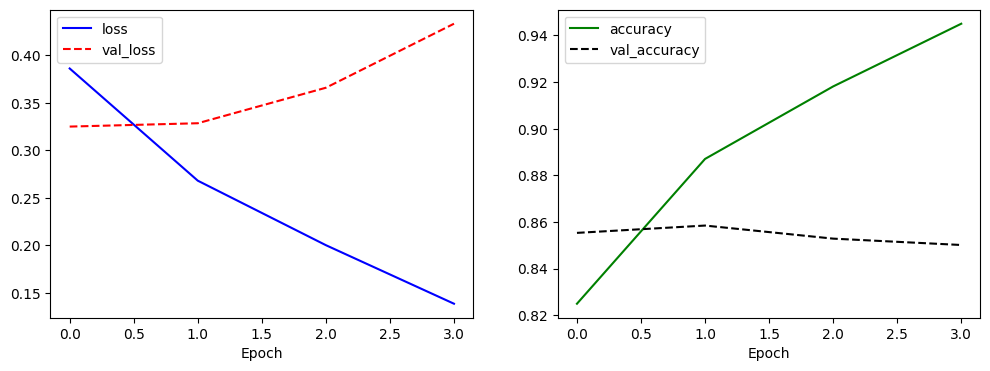

In [59]:
# loss, accuracy 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

In [60]:
# 토큰화 평가
test_tensor, _, _ = sp_tokenize(s, test['document'])
y_test = test['label'].values

test_loss, test_accuracy = model.evaluate(test_tensor, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f"sp_tokenize 정확도: {test_accuracy * 100:.2f}%")

1402/1402 [==============================] - 18s 13ms/step - loss: 0.4338 - accuracy: 0.8464
Test Loss: 0.43380415439605713
Test Accuracy: 0.8463819622993469
sp_tokenize 정확도: 84.64%


이전 노트북에서 진행했던 vocab_size = 8,000개 보단 성능이 0.37% 더 좋아짐

## voacb_size 24000으로 변경

In [61]:

# 문장 추출
corpus = train['document'].tolist()

# vocab_size에 대한 실험은 나중에
vocab_size = 24000

# SentencePiece model 학습

# 학습에 필요한 파일 생성
with open(data_path + '/nsmc_vocab24_spm.txt', 'w') as f:
    for row in corpus:
        f.write(str(row) + '\n')

In [62]:
# SentencePiece model 학습
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(data_path + '/nsmc_vocab24_spm.txt', vocab_size)
)

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=/home/mjun/GoingDeeper/data/nsmc/nsmc_vocab24_spm.txt --model_prefix=korean_spm --vocab_size=24000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/mjun/GoingDeeper/data/nsmc/nsmc_vocab24_spm.txt
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 24000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_l

In [63]:
# SentencePiece model load
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [64]:
# tokenizer 함수 정의
def sp_tokenize(s, corpus):
    
    tensor = []
    
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
        
    with open('./korean_spm.vocab', 'r') as f:
        vocab = f.readlines()
    
    word_index = {}
    index_word = {}
    
    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]
        
        word_index.update({idx:word})
        index_word.update({word:idx})
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

In [65]:
# 데이터 토큰화
train_tensor, train_word_index, train_index_word = sp_tokenize(s, train['document'])

In [66]:
y = train['label'].values

# split train data
from sklearn.model_selection import train_test_split
tensor_train, tensor_val, y_train, y_val = train_test_split(train_tensor, y, test_size = 0.2, random_state = 42)

In [67]:
# bi-lstm RNN 모델 생성 - dropout 적용
from tensorflow.keras import layers

model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [68]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         3072000   
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 3729665 (14.23 MB)
Trainable params: 372

In [69]:
# callback 함수 정의    
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 모델 학습
history_24 = model.fit(tensor_train, y_train, epochs=10, callbacks=[early_stopping] ,validation_data=(tensor_val, y_val), verbose=1)

Epoch 1/10
3345/3345 [==============================] - 173s 50ms/step - loss: 0.3861 - accuracy: 0.8249 - val_loss: 0.3265 - val_accuracy: 0.8549
Epoch 2/10
3345/3345 [==============================] - 101s 30ms/step - loss: 0.2497 - accuracy: 0.8965 - val_loss: 0.3300 - val_accuracy: 0.8588
Epoch 3/10
3345/3345 [==============================] - 101s 30ms/step - loss: 0.1741 - accuracy: 0.9311 - val_loss: 0.3924 - val_accuracy: 0.8524
Epoch 4/10
3345/3345 [==============================] - 97s 29ms/step - loss: 0.1079 - accuracy: 0.9595 - val_loss: 0.4971 - val_accuracy: 0.8441


In [70]:
# 토큰화 평가
test_tensor, _, _ = sp_tokenize(s, test['document'])
y_test = test['label'].values

test_loss, test_accuracy = model.evaluate(test_tensor, y_test, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f"sp_tokenize 정확도: {test_accuracy * 100:.2f}%")

1402/1402 [==============================] - 18s 12ms/step - loss: 0.5022 - accuracy: 0.8405
Test Loss: 0.5022438168525696
Test Accuracy: 0.8405396342277527
sp_tokenize 정확도: 84.05%


loss도 증가했고 성능도 젤 안좋게 나옴

추측
- vocab_size가 너무 작은 경우, 더 많은 단어를 subword 단위로 잘라야하고 이로 인해서 더 긴 시퀀스를 생성해야 할 수 있어서 문맥을 충분히 반영 못 할 수 있다.
- vocab_size가 너무 큰 경우, 상대적으로 많은 단어들을 고유 토큰?으로 처리해서 subword 분해가 덜 되고 희귀한 단어가 그대로 포함되어서 문제가 발생할 수도 있다.
- 분해와 희소성의 밸런스가 중요한듯